In [338]:
### Encoding model for iEEG
# Pedro Pinheiro-Chagas
# Adapted from Christopher Holdgraf's git repo: 
#(https://github.com/choldgraf/paper-encoding_decoding_electrophysiology)

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from modelingtools import delay_time_series, plot_activity_on_brain

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier





/Users/pinheirochagas/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### 1. The data
Task: MMR - calculation, memory verification and "rest" ('17+5=23', 'I ate fruit today'). <br />
Type of data: epoched and baseline corrected, all concatenated. <br />
Brain feature: Normalized HFB power.  <br />

Stimuli features:
0. Task, trial, time, block
1. Task
    - condition(calculation, memory, rest) 
    - type (active, passive)
2. Calculation specs
    - number_format (digit, word, dot)
    - operand_1
    - operand_2
    - operand_min
    - operand_max
    - operation (addition, subtraction, multiplication)
    - ls_sl
    - result 
    - cross_decade
    - presented_result
    - abs_deviant
    - number of digits
3. Memory specs
    - memory type (autobio, self-external, self-internal, fact)
4. Behavior
    - RT
    - Accuracy
    - RT_lock
    
The features were already selected and the encoding matrix was consctructed in Matlab and saved as csv.

#### Plot examplar encoding matrix:

(-0.5, 7816.5, 2741.5, -0.5)

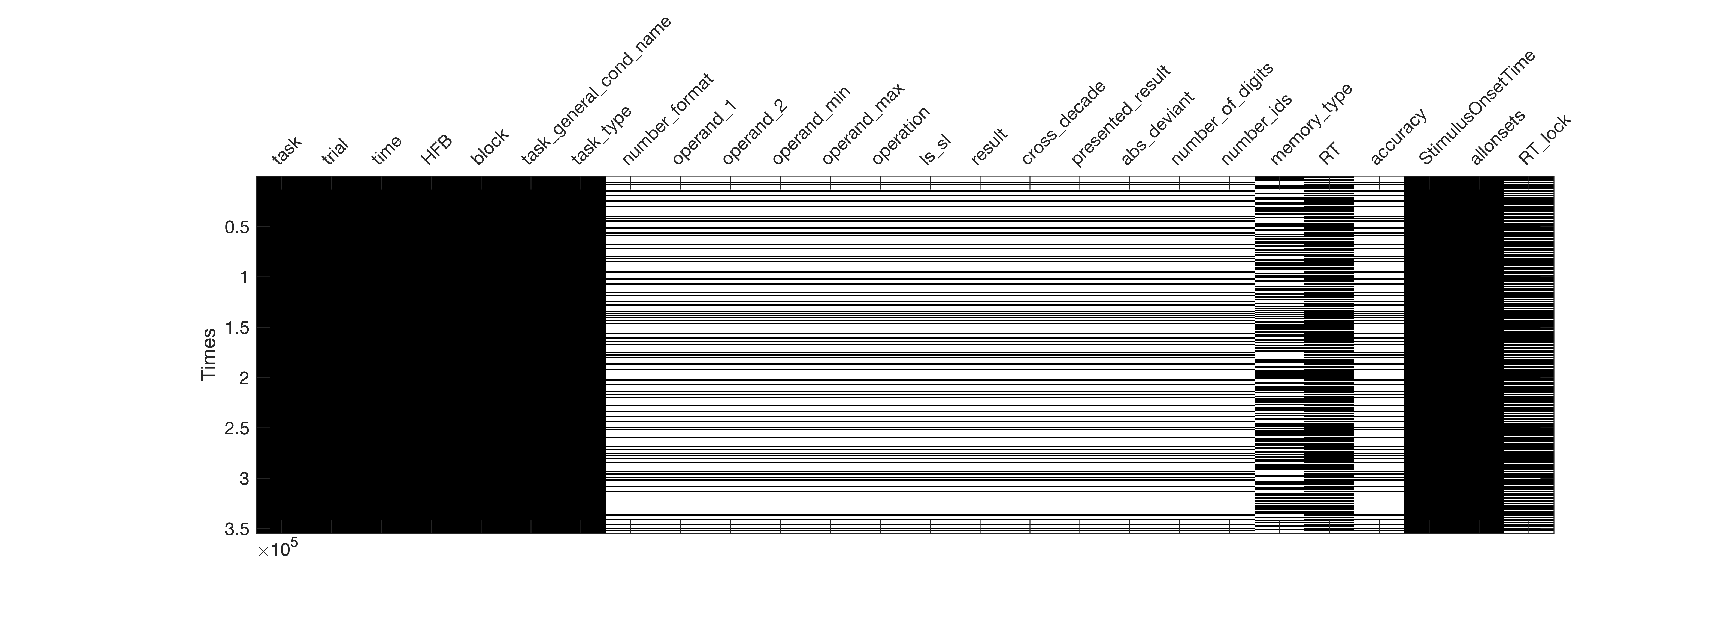

In [2]:
im = plt.imread('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/figures/encoding_matrix.png') 
fig, ax = plt.subplots(figsize=(30, 15))
ax.imshow(im)
plt.axis('off')

### Load the data



In [109]:
#data = np.genfromtxt('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/data/data.csv', delimiter=',')
data = pd.read_csv('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/data/data_61.csv') 


In [113]:
# Recode task
data.loc[data.loc[:,'task_general_cond_name']==4, 'task_general_cond_name'] = 3
data.loc[data.loc[:,'task_general_cond_name']==6, 'task_general_cond_name'] = 2
data.loc[data.loc[:,'task_general_cond_name']==7, 'task_general_cond_name'] = 1

### Plot all blocks concatenated

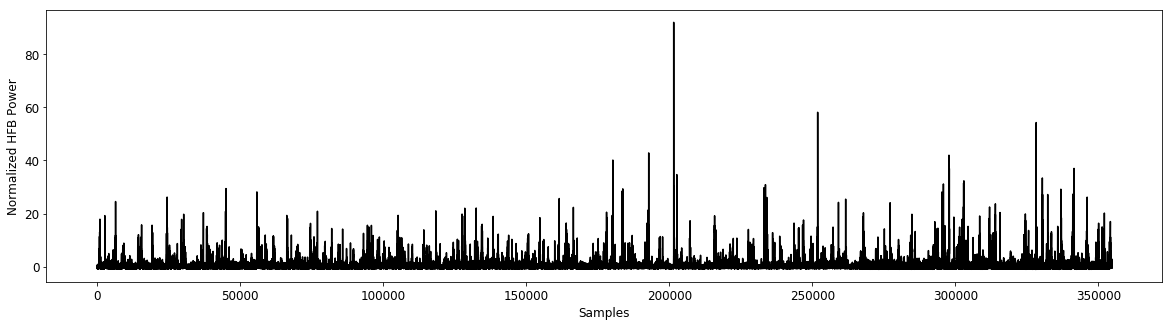

In [114]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(data.loc[:,'HFB'], color='k')
plt.xlabel('Samples')
plt.ylabel('Normalized HFB Power')
plt.rcParams.update({'font.size': 20})

### Plot blocks saparated

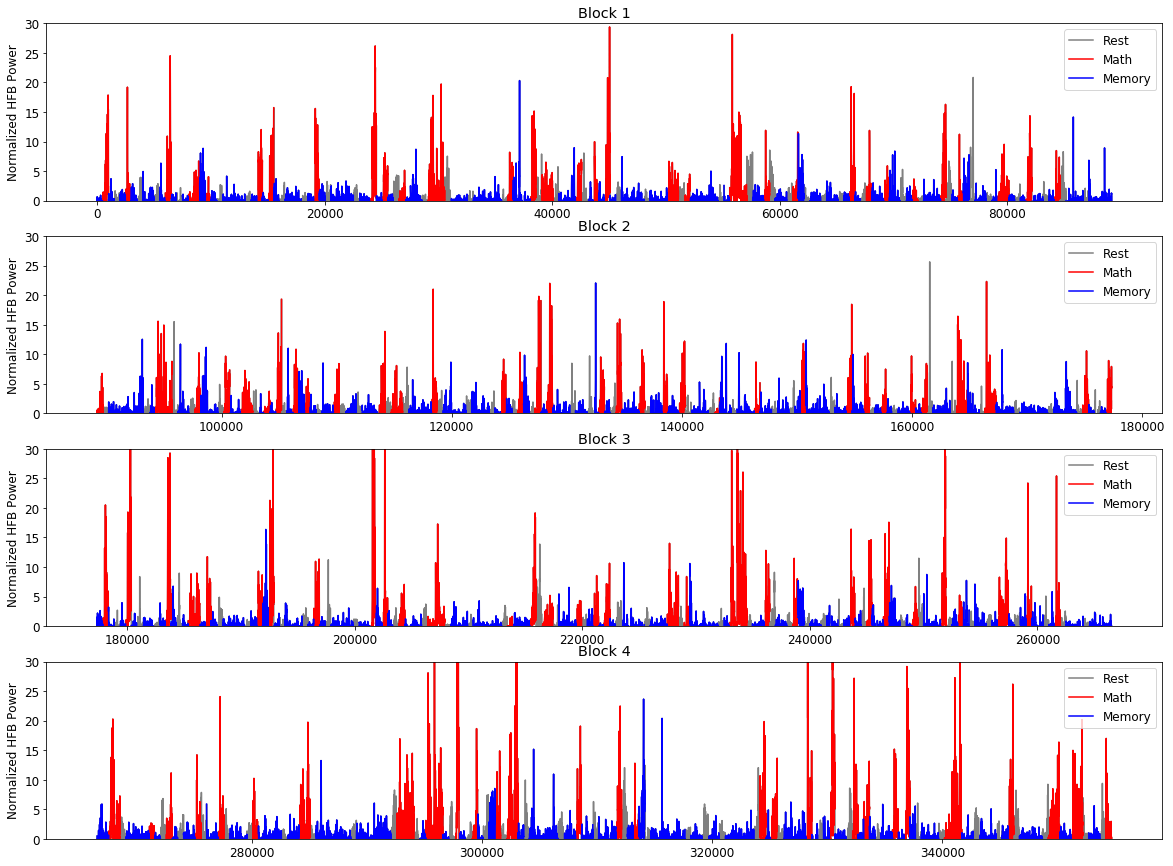

In [116]:
n_blocks = np.int(np.max(data.loc[:,'block']))
fig, ax = plt.subplots(n_blocks,1,figsize=(20, 15))

# Filter trials
math_trials = data.loc[:,'HFB'].copy()
math_trials[data.loc[:,'task_general_cond_name']!=3] = np.nan
memo_trials = data.loc[:,'HFB'].copy()
memo_trials[data.loc[:,'task_general_cond_name']!=2] = np.nan

for i in range(n_blocks):
    #ax[i].plot(samples[data[:,4]==i+1], data[data[:,4]==i+1,3])
    ax[i].plot(data.loc[data.loc[:,'block']==i+1,'HFB'], color=[0.5,0.5,0.5], label="Rest")
    ax[i].plot(math_trials[data.loc[:,'block']==i+1], 'r', label="Math")
    ax[i].plot(memo_trials[data.loc[:,'block']==i+1], 'b', label="Memory")
    ax[i].set_ylim([0,30])
    ax[i].set_title('Block ' + str(i+1))
    #ax[i].set_xlabel('Samples')
    ax[i].set_ylabel('Normalized HFB Power')
    plt.rcParams.update({'font.size': 12}) 
    ax[i].legend()


In [117]:
features = np.array(data.loc[:,'task_general_cond_name'])
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)

In [118]:
features_reshape = np.reshape(features, (trials, times))
np.shape(features_reshape)
features_reshape = np.expand_dims(features_reshape, axis=1)
np.shape(features_reshape)

(708, 1, 501)

In [119]:
delays = np.linspace(-0.5, 0., 20)
X_delayed = delay_time_series(features_reshape, delays, 500)

In [120]:
np.shape(X_delayed)

(708, 1, 20, 501)

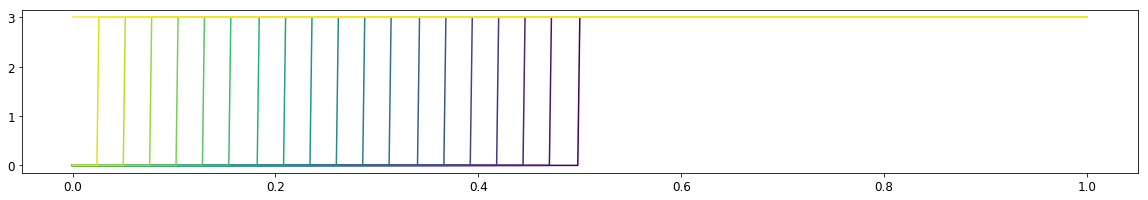

In [121]:
fig, ax = plt.subplots(figsize=(20, 3))
colors = plt.cm.viridis(np.linspace(0,1,20))

for i in range(20):
    #ax[i].plot(samples[data[:,4]==i+1], data[data[:,4]==i+1,3])
    ax.plot(np.unique(data.loc[:,'time']), np.squeeze(X_delayed[1,0,i,:]), color=colors[i])

Text(0.5,1,'Time-Delayed Task Name')

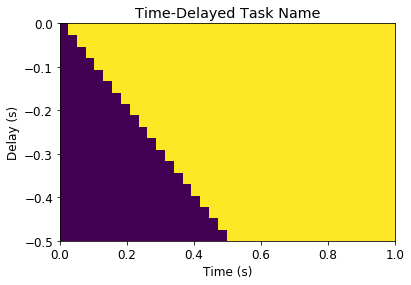

In [122]:
times = np.unique(data.loc[:,'time'])
fig, ax = plt.subplots()
ax.pcolormesh(times, delays,
              X_delayed[1,0,:,:], cmap='viridis')
ax.axis('tight')
ax.set_ylabel('Delay (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Time-Delayed Task Name')

In [123]:
# Concatenate back the delayed features
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

In [124]:
# Define the dependent variable
y = np.array(data.loc[:,'HFB']) # HFB

In [128]:
# Fit the model
est = make_pipeline(StandardScaler(), LinearRegression())
est.fit(X_env, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [129]:
est.steps[-1][-1].coef_

array([-0.00305834, -0.00376673, -0.02212705,  0.02889198,  0.02425575,
       -0.07384765, -0.02922719,  0.05402607,  0.13130945,  0.11811194,
        0.0572498 , -0.0070446 , -0.03364303,  0.0124559 ,  0.01444815,
        0.00815618, -0.01771975,  0.0025047 , -0.0167321 , -0.17869854])

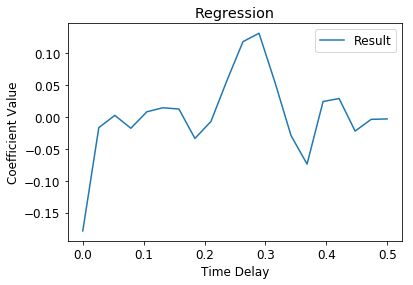

In [130]:
# Plot results
fig, ax = plt.subplots()
ax.plot(np.abs(delays), est.steps[-1][-1].coef_, label = 'Result')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

In [133]:
# Choose another feature
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
features = np.array(data.loc[:,'result'])

features_reshape = np.reshape(features, (trials, times))
features_reshape = np.expand_dims(features_reshape, axis=1)
X_delayed = delay_time_series(features_reshape, delays, 500)
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

est_res = make_pipeline(StandardScaler(), LinearRegression())
est_res.fit(X_env, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

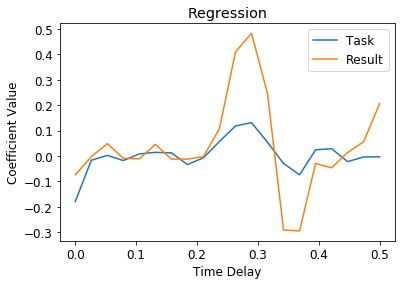

In [135]:
# Plot results
fig, ax = plt.subplots()
ax.plot(np.abs(delays), est.steps[-1][-1].coef_, label = 'Task')
ax.plot(np.abs(delays), est_res.steps[-1][-1].coef_,label = 'Result')
#ax.plot(np.abs(delays), est_cd.steps[-1][-1].coef_,label = 'Cross decade')
#ax.plot(np.abs(delays), est_task.steps[-1][-1].coef_,label = 'Task')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

In [337]:
features

array([0., 0., 0., ..., 1., 1., 1.])

In [108]:
X_env

array([[0., 0., 0., ..., 0., 0., 6.],
       [0., 0., 0., ..., 0., 0., 6.],
       [0., 0., 0., ..., 0., 0., 6.],
       ...,
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.]])